In [1]:
# Install necessary libraries
!pip install kaggle
!pip install tweepy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install wordcloud
!pip install nltk

In [2]:
# configure the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


import Twitter Sentiment dtaset


In [3]:
# API to fetch the dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 77% 62.0M/80.9M [00:00<00:00, 187MB/s]
100% 80.9M/80.9M [00:00<00:00, 185MB/s]


In [4]:
# extracting the compressed dataset

from zipfile import ZipFile
dataset='/content/sentiment140.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print(' The dataset is extracted')


 The dataset is extracted


importing the Dependencies


In [5]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pickle


In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
# Printing the stopwords in English
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

DATA PROCESSING

In [8]:
# loading the data from csv file to pandas dataframe
twitter_data=pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1')

In [9]:
# checkin the number of rows and columns
twitter_data.shape

(1599999, 6)

In [10]:
# printing the first 5 rows of the dataframe
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [11]:
# naming the columns and reading the dataset again

column_names=['target','id','date','flag','user','text']
twitter_data=pd.read_csv('/content/training.1600000.processed.noemoticon.csv', names=column_names,encoding = 'ISO-8859-1')

In [12]:
# checkin the number of rows and columns
twitter_data.shape

(1600000, 6)

In [13]:
# printing the first 5 rows of the dataframe
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
# counting the number of missing values in the dataset
twitter_data.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [15]:
# checking the distribution of target column
twitter_data['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

Converting  the target "4" to "1"

In [16]:
twitter_data.replace({'target':{4:1}},inplace=True)

In [17]:
# checking the distribution of target column
twitter_data['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

0 ------> Negative Tweet
1 ------> Positive Tweet

**stemming**

Stemming is a process to reducing a word to its Root word


example:actor,acting=act

In [18]:
port_stem = PorterStemmer()

In [19]:
def stemming(text):
    port_stem = PorterStemmer()  # Correctly define the PorterStemmer instance
    stemmed_content = text.lower()  # Convert to lower case
    words = stemmed_content.split()  # Split text into words
    stop_words = set(stopwords.words('english'))  # Get the set of stopwords
    # Stem each word and remove stopwords
    stemmed_words = [port_stem.stem(word) for word in words if word not in stop_words]
    return ' '.join(stemmed_words)


In [20]:
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming)

In [21]:
print(twitter_data)

         target          id                          date      flag  \
0             0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1             0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2             0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3             0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4             0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1599995       1  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996       1  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997       1  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998       1  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999       1  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                               text  \
0        _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Aww

In [22]:
twitter_data.head()

,target,id,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset can't updat facebook text it... might cr...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@kenichan dive mani time ball. manag save 50% ...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, behav all. i'm mad. here?..."


In [23]:
print(twitter_data['stemmed_content'])

0          @switchfoot http://twitpic.com/2y1zl - awww, t...
1          upset can't updat facebook text it... might cr...
2          @kenichan dive mani time ball. manag save 50% ...
3                            whole bodi feel itchi like fire
4          @nationwideclass no, behav all. i'm mad. here?...
                                 ...                        
1599995                       woke up. school best feel ever
1599996    thewdb.com - cool hear old walt interviews! â...
1599997                      readi mojo makeover? ask detail
1599998    happi 38th birthday boo alll time!!! tupac ama...
1599999    happi #charitytuesday @thenspcc @sparkschar @s...
Name: stemmed_content, Length: 1600000, dtype: object


In [24]:
# separating the data and label
X=twitter_data['stemmed_content'].values
Y=twitter_data['target'].values

In [25]:
print(X)

["@switchfoot http://twitpic.com/2y1zl - awww, that' bummer. shoulda got david carr third day it. ;d"
 "upset can't updat facebook text it... might cri result school today also. blah!"
 '@kenichan dive mani time ball. manag save 50% rest go bound' ...
 'readi mojo makeover? ask detail'
 'happi 38th birthday boo alll time!!! tupac amaru shakur'
 'happi #charitytuesday @thenspcc @sparkschar @speakinguph4h']


In [26]:
 print(Y)

[0 0 0 ... 1 1 1]


Splitting the data to training data and test data

In [27]:
 X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=2)

In [28]:
print(X.shape,X_train.shape,X_test.shape)

(1600000,) (1280000,) (320000,)


In [29]:
print(X_train)

['watch saw iv drink lil wine' "@hatermagazin i'm in!"
 'even though favourit drink think vodka coke wipe mind time think im gonna find new drink'
 ... 'eager monday afternoon'
 "hope everyon mother great day! can't wait hear guy store tomorrow!"
 'love wake folgers. bad voic deeper his.']


In [30]:
print(X_test)

['@mmangen - fine! much time chat twitter. hubbi back summer &amp; tend domin free time.'
 'ah may show w/ ruth kim &amp; geoffrey sanhueza'
 '@ishatara mayb bay area thang dammit!' ...
 '@destini41 nevertheless hooray! 4700 member wonder safe trip!'
 'feel well' '@supersandro !!!! thank you!']


In [31]:
# converting the textual data to numerical data

vectorizer=TfidfVectorizer()

X_train=vectorizer.fit_transform(X_train)
X_test=vectorizer.transform(X_test)

In [32]:
print(X_train)

  (0, 555967)	0.448720931098355
  (0, 311959)	0.4213989894780769
  (0, 166830)	0.37842601975344053
  (0, 254267)	0.5248773503338933
  (0, 453116)	0.35795997954657904
  (0, 548734)	0.272460245511403
  (1, 247278)	0.4216951552804088
  (1, 226262)	0.9067376665899747
  (2, 375364)	0.1668911233829414
  (2, 193769)	0.20184466588151023
  (2, 214788)	0.18696286991487276
  (2, 245846)	0.16108271281506448
  (2, 516778)	0.15260594669966604
  (2, 349418)	0.2408559466227688
  (2, 556376)	0.33614580595161764
  (2, 129252)	0.3117944515681846
  (2, 545128)	0.32796751926832934
  (2, 513655)	0.3201716231105769
  (2, 190522)	0.29198833954883197
  (2, 514638)	0.18602125106063971
  (2, 184426)	0.1903000016055046
  (2, 166830)	0.46135196432581554
  (3, 239574)	0.38340980743118147
  (3, 519470)	0.2688525366668751
  (3, 493022)	0.3914375454549087
  :	:
  (1279996, 410084)	0.21029847974488325
  (1279996, 315358)	0.2219434776579764
  (1279996, 378383)	0.1776339096901187
  (1279996, 520651)	0.1868087345439146
  

In [33]:
print(X_test)

  (0, 530649)	0.17887663933344994
  (0, 516778)	0.31514526424889533
  (0, 505258)	0.3459496612358391
  (0, 492691)	0.21841828884993894
  (0, 364065)	0.17667781375470604
  (0, 354509)	0.449467530296984
  (0, 238369)	0.2869441563378548
  (0, 200572)	0.23596147172673212
  (0, 193829)	0.2532904390317208
  (0, 163021)	0.37372158998727745
  (0, 117476)	0.26691751430897404
  (0, 74691)	0.1610538837848407
  (0, 55622)	0.17041370659097008
  (1, 466635)	0.24404319903374125
  (1, 445343)	0.48174286114843634
  (1, 337825)	0.2840187026690571
  (1, 291622)	0.4070550884371154
  (1, 208893)	0.5712382041014992
  (1, 55622)	0.20816041520057577
  (1, 45607)	0.3039118621705182
  (2, 507224)	0.4337196481249129
  (2, 337915)	0.2587039123196698
  (2, 252255)	0.5874470296410402
  (2, 143688)	0.3624696061947235
  (2, 78469)	0.3786845038674409
  :	:
  (319995, 526794)	0.39930162664337965
  (319995, 417479)	0.3357981149453034
  (319995, 407164)	0.2582052217116053
  (319995, 384821)	0.40236048960872395
  (319995,

Training the Machine Learning Model

Logistic Regression

In [34]:
model=LogisticRegression(max_iter=1000)

In [35]:
model.fit(X_train,Y_train)

LogisticRegression(max_iter=1000)

Model Evalution

Accurracy score

In [36]:
# accuracy score on the training data
X_train_prediction=model.predict(X_train)
training_data_accuracy=accuracy_score(Y_train,X_train_prediction)

In [37]:
print('Accuracy score on the training data:',training_data_accuracy)

Accuracy score on the training data: 0.8169171875


In [38]:
# accuracy score on the testing data
X_test_prediction=model.predict(X_test)
test_data_accuracy=accuracy_score(Y_test,X_test_prediction)

In [39]:
print('Accuracy score on the test data:',test_data_accuracy)

Accuracy score on the test data: 0.782253125


Model accuracy = 78.22%

In [40]:
import pickle

In [41]:
filename='trained_model.sav'
pickle.dump(model,open(filename,'wb'))
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))

# Optionally download the files to your local machine
#from google.colab import files
#files.download('trained_model.sav')
#files.download('vectorizer.pkl')

Using the saved model for future prediction

In [42]:
# loading the saved model
loaded_model=pickle.load(open('/content/trained_model.sav','rb'))

In [43]:
X_new = X_test[200]
print(Y_test[200])

prediction = model.predict(X_new)
print(prediction)

if(prediction[0]==0):
  print('Negative Tweet')

else:
    print('Positive Tweet')

1
[1]
Positive Tweet


In [44]:
X_new = X_test[3]
print(Y_test[3])

prediction = model.predict(X_new)
print(prediction)

if(prediction[0]==0):
  print('Negative Tweet')

else:
    print('Positive Tweet')

0
[0]
Negative Tweet


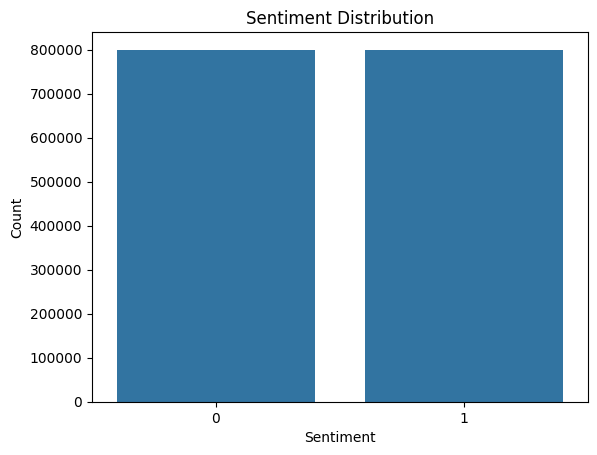

In [45]:
# Visualize sentiment distribution
sns.countplot(x='target', data=twitter_data)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()